In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import pandas as pd
from rdflib import Graph, Literal, RDF, URIRef, Namespace
from rdflib.namespace import XSD, RDFS, OWL
import networkx as nx
from owlready2 import *
import rdflib

from rdflib import Graph, Namespace, Literal, RDF, URIRef   # <-- RDFlib version overrides Owlready2




# Only import what you need from owlready2
from owlready2 import World








# Hybrid Neuro-Symbolic System for Industrial Diagnostics

This project implements a hybrid decision-support system for diagnosing CNC Spindle Overheat events, combining Bayesian Networks (BN) for probabilistic reasoning with Knowledge Graphs (KG) for semantic explanation.


## Methodology & Data Usage

1. **Probabilistic Reasoning (The Bayesian Network)**

    **Data Source**: We will utilize telemetry.csv, which contains continuous sensor readings such as Temperature, Vibration, CoolantFlow, and RPM.

    **Purpose**: The Bayesian Network (BN) serves as the "System 1" component, handling the stochastic nature of physical sensors and the uncertainty inherent in diagnosis.

    **Implementation**: We will construct a causal model (Generative approach) where latent root causes (e.g., BearingWear, FanFault) influence observable symptoms. The sensor data will be discretized to calculate Conditional Probability Tables (CPTs), allowing us to infer the posterior probability of failure, P(Cause∣Evidence), using libraries like pgmpy.

2. Symbolic Reasoning (The Knowledge Graph)

    **Data Source**: Domain expertise regarding maintenance protocols, spare parts, repair durations, and costs:

        -data/components.csv
        -data/causes.csv
        -data/symptoms.csv
        -data/relations.csv
        -data/procedures.csv


    **Purpose**: The Knowledge Graph (KG) serves as the "System 2" component, providing the semantic context that the probabilistic model lacks.

    **Implementation**: Using RDF and OWL standards, we will model the relationships between specific failure modes and their required maintenance procedures. This allows the system to map the BN's probabilistic diagnosis to a deterministic, actionable solution (e.g., "Replace Bearing X, Cost: $Y, Time: Z").

In this section, we prepare the raw data for the Bayesian Network. We will analyze both the sensor readings **(telemetry.csv)** and the failure logs **(labels.csv)**.

# 1 'telemetry.csv' EDA 

### 1.1 : Load and Inspect Data

In [43]:
df_telemetry = pd.read_csv('data/telemetry.csv')
display(df_telemetry.head())

,timestamp,machine_id,spindle_temp,ambient_temp,vibration_rms,coolant_flow,feed_rate,spindle_speed,load_pct,power_kw,tool_wear
0,2025-01-01T00:00:00,M-A,73.96,24.36,0.871,1.050,0.9,3600,0.294,3.193,0.000
1,2025-01-01T00:05:00,M-A,53.38,22.87,0.536,1.083,1.3,800,0.329,2.149,0.000
2,2025-01-01T00:10:00,M-A,58.12,24.59,0.455,1.025,0.9,1200,0.369,2.457,0.001
3,2025-01-01T00:15:00,M-A,58.08,23.05,0.680,0.977,0.7,1200,0.479,2.702,0.001
4,2025-01-01T00:20:00,M-A,55.37,24.28,0.663,1.072,1.1,800,0.328,2.148,0.001


In [44]:
# Convert timestamp to datetime objects for accurate plotting
df_telemetry['timestamp'] = pd.to_datetime(df_telemetry['timestamp'])

# Inspect the first few rows and summary statistics
print("Dataset Shape:", df_telemetry.shape)
display(df_telemetry.head())
display(df_telemetry.describe())

Dataset Shape: (103680, 11)


,timestamp,machine_id,spindle_temp,ambient_temp,vibration_rms,coolant_flow,feed_rate,spindle_speed,load_pct,power_kw,tool_wear
0,2025-01-01 00:00:00,M-A,73.96,24.36,0.871,1.050,0.9,3600,0.294,3.193,0.000
1,2025-01-01 00:05:00,M-A,53.38,22.87,0.536,1.083,1.3,800,0.329,2.149,0.000
2,2025-01-01 00:10:00,M-A,58.12,24.59,0.455,1.025,0.9,1200,0.369,2.457,0.001
3,2025-01-01 00:15:00,M-A,58.08,23.05,0.680,0.977,0.7,1200,0.479,2.702,0.001
4,2025-01-01 00:20:00,M-A,55.37,24.28,0.663,1.072,1.1,800,0.328,2.148,0.001


,timestamp,spindle_temp,ambient_temp,vibration_rms,coolant_flow,feed_rate,spindle_speed,load_pct,power_kw,tool_wear
count,103680,103680.000000,103680.000000,103680.000000,103680.000000,103680.000000,103680.000000,103680.000000,103680.000000,103680.000000
mean,2025-02-14 23:57:30,68.136173,22.001607,0.984043,0.532744,1.040546,1849.834105,0.512752,3.343900,0.952667
min,2025-01-01 00:00:00,50.080000,12.170000,0.364000,0.200000,0.700000,800.000000,0.050000,1.690000,0.000000
25%,2025-01-23 11:58:45,63.317500,17.980000,0.863000,0.428000,0.900000,1200.000000,0.355000,2.643000,1.000000
50%,2025-02-14 23:57:30,67.220000,21.995000,0.973000,0.481000,1.100000,2000.000000,0.503000,3.138000,1.000000
75%,2025-03-09 11:56:15,72.580000,26.020000,1.111000,0.581000,1.300000,2800.000000,0.666000,3.896000,1.000000
max,2025-03-31 23:55:00,88.620000,31.860000,1.536000,1.200000,1.500000,3600.000000,1.000000,6.881000,1.000000
std,NaN,6.431063,4.429376,0.185500,0.158853,0.250903,896.620676,0.201694,0.858452,0.171522


**Note** : As we noticed from above, there are different machines in the csv . So we will manipulate our dataset in order to group the data by machine and order by timestamp;

In [45]:
df_telemetry = df_telemetry.sort_values(by=['machine_id', 'timestamp']).reset_index(drop=True)

# 3. Validation
print("Data Sorted. Unique Machines:", df_telemetry['machine_id'].unique())
display(df_telemetry.head())

Data Sorted. Unique Machines: ['M-A' 'M-B' 'M-C' 'M-D']


,timestamp,machine_id,spindle_temp,ambient_temp,vibration_rms,coolant_flow,feed_rate,spindle_speed,load_pct,power_kw,tool_wear
0,2025-01-01 00:00:00,M-A,73.96,24.36,0.871,1.050,0.9,3600,0.294,3.193,0.000
1,2025-01-01 00:05:00,M-A,53.38,22.87,0.536,1.083,1.3,800,0.329,2.149,0.000
2,2025-01-01 00:10:00,M-A,58.12,24.59,0.455,1.025,0.9,1200,0.369,2.457,0.001
3,2025-01-01 00:15:00,M-A,58.08,23.05,0.680,0.977,0.7,1200,0.479,2.702,0.001
4,2025-01-01 00:20:00,M-A,55.37,24.28,0.663,1.072,1.1,800,0.328,2.148,0.001


### 1.2 Checking for Different Scales and Noise

Bayesian Networks  require discretization (binning values into "Low", "Medium", "High", for example). So checking the scales of our features, is vital.

For example:

- If we plot vibration_rms (0-5 range) on the same chart as spindle_speed (0-5000 range), the vibration data will appear as a flat line at zero. This creates issues if we try to normalize data globally.

- Raw sensors have "jitter." If we discretize raw data, a stable machine might flicker between "Normal" and "Warning" bins just because of sensor noise (e.g., 59.9°C vs 60.1°C). This causes unstable probabilities in the BN.

So we will plot both 'spindle_temp' and 'vibration_rms' simulataniously so we can make conclusions on the differences of scales

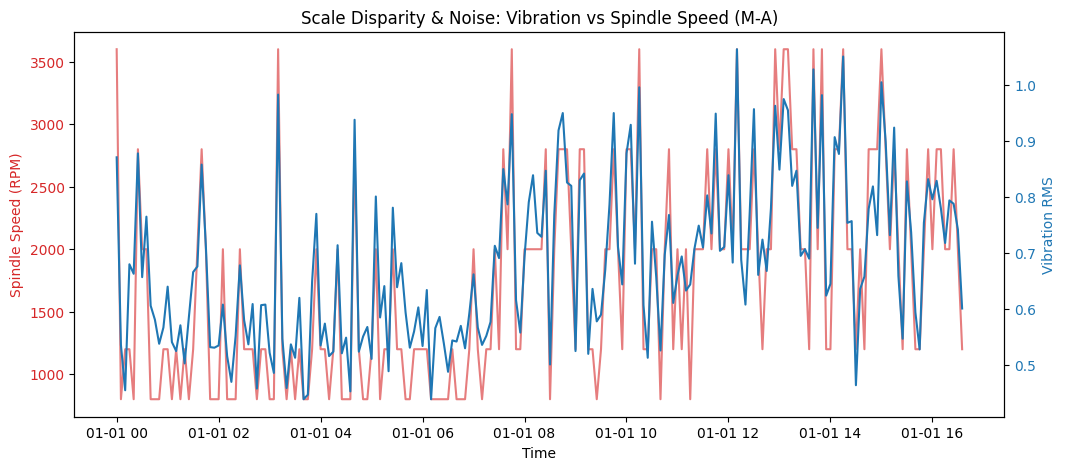

In [46]:
# 1. Select a single machine to visualize (e.g., the first one found)
target_machine = df_telemetry['machine_id'].unique()[0]
df_single = df_telemetry[df_telemetry['machine_id'] == target_machine].sort_values('timestamp')

# 2. Setup the plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot Spindle Speed (Large Scale)
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Spindle Speed (RPM)', color=color)
# Plot the first 200 points of THIS specific machine
ax1.plot(df_single['timestamp'][:200], df_single['spindle_speed'][:200], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot Vibration (Small Scale)
color = 'tab:blue'
ax2.set_ylabel('Vibration RMS', color=color)
ax2.plot(df_single['timestamp'][:200], df_single['vibration_rms'][:200], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'Scale Disparity & Noise: Vibration vs Spindle Speed ({target_machine})')
plt.show()

**Conclusions**:

- Scale Disparity is Real: One sensor is in the thousands (0-4000), the other is tiny (0-1.5). This proves we must normalize or discretize carefully; otherwise, the model might ignore the small numbers.

- Noise is High: The blue line is extremely jagged. This proves we cannot use raw data. We must apply smoothing (like a rolling average) before building the Bayesian Network, or the model will panic at every random micro-spike.

### 1.3 Checking for temporal Correlation (The I.I.D. Violation)

A standard Bayesian Network treats every row in your CSV as a completely new, unrelated "roll of the dice".

For example, 'spindle_temp' at 10:01 AM is almost exactly the same as at 10:00 AM. They are not independent. If we feed raw rows into the BN, the model will "over-count" evidence. It will become wildly overconfident because it thinks it saw 1,000 independent examples of high heat, when it actually just saw 1 heat event lasting 1,000 seconds.

So first we will check for Autocorrelation for Temperature, wich is the "worst-case scenario" for I.I.D. violations (A massive metal spindle cannot heat up or cool down instantly. It must correlate with its past state)

Corrected Autocorrelation at Lag 1 (M-A - Spindle Temp): 0.3163


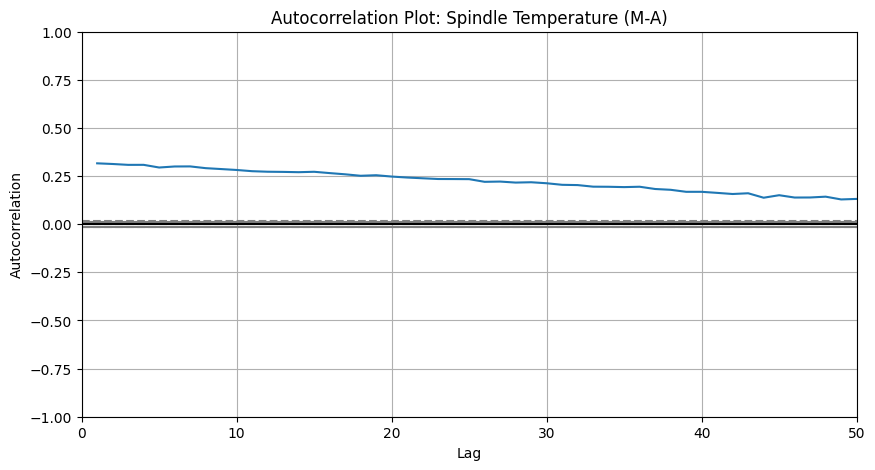

In [47]:
target_machine = df_telemetry['machine_id'].unique()[0]
df_single_machine = df_telemetry[df_telemetry['machine_id'] == target_machine].sort_values('timestamp')

plt.figure(figsize=(10, 5))

# 2. Calculate autocorrelation for Spindle Temperature on this specific machine
# Lag 1 means: How correlated is row(t) with row(t-1)?
corr_1 = df_single_machine['spindle_temp'].autocorr(lag=1)
print(f"Corrected Autocorrelation at Lag 1 ({target_machine} - Spindle Temp): {corr_1:.4f}")

# 3. Visual proof
# This plots the correlation of the series with itself at different time lags
autocorrelation_plot(df_single_machine['spindle_temp'])
plt.title(f'Autocorrelation Plot: Spindle Temperature ({target_machine})')

# Limit x-axis to the first 50 lags (minutes) to see the immediate dependency
plt.xlim(0, 50)
plt.show()

We expected spindle_temp to show high autocorrelation (values near 1.0). Physically, large metal spindles usually retain heat, meaning the temperature at Minute 1 should strongly predict the temperature at Minute 2.

However, we observed low autocorrelation (~0.30).

**This suggests the machine changes state faster than our sampling rate (5 minutes). In that 5-minute gap, the machine can stop, cool down, and start a new job, breaking the "thermal memory."**

We will check for other correlations: 

In [48]:
target_machine = df_telemetry['machine_id'].unique()[0]
df_single = df_telemetry[df_telemetry['machine_id'] == target_machine].sort_values('timestamp')

print(f"--- Lag-1 Autocorrelation Analysis for {target_machine} ---")
print(f"{'Sensor':<20} | {'Correlation':<12} | {'Interpretation'}")
print("-" * 50)

# 2. Get all numeric columns automatically
numeric_cols = df_single.select_dtypes(include=[np.number]).columns

# 3. Calculate and Print
results = []
for col in numeric_cols:
    corr = df_single[col].autocorr(lag=1)
    
    # Simple interpretation logic
    if corr > 0.9:
        interp = "Cumulative / Stable"
    elif corr > 0.5:
        interp = "High Dependency"
    else:
        interp = "Volatile / Fast"
        
    results.append((col, corr, interp))

# Sort by correlation (Highest to Lowest) for better readability
results.sort(key=lambda x: x[1], reverse=True)

for col, corr, interp in results:
    print(f"{col:<20} : {corr:.4f}       ({interp})")

--- Lag-1 Autocorrelation Analysis for M-A ---
Sensor               | Correlation  | Interpretation
--------------------------------------------------
tool_wear            : 1.0000       (Cumulative / Stable)
ambient_temp         : 0.9748       (Cumulative / Stable)
coolant_flow         : 0.8684       (High Dependency)
load_pct             : 0.5397       (High Dependency)
vibration_rms        : 0.4384       (Volatile / Fast)
power_kw             : 0.4347       (Volatile / Fast)
spindle_temp         : 0.3163       (Volatile / Fast)
feed_rate            : 0.2184       (Volatile / Fast)
spindle_speed        : 0.2019       (Volatile / Fast)


This table justifies exactly how we need to treat each variable in the Bayesian Network.

- The "Context" Variables (Correlation > 0.9)

    tool_wear & ambient_temp: These are stable. They act as the "background context."

    BN Strategy: We can use these raw values directly because they don't jump around. A high ambient temp at 10:00 is reliable evidence for 10:05.

- The "State" Variables (Correlation ~ 0.5 - 0.8)

    coolant_flow & load_pct: These likely represent the Job State. If coolant is high, the machine is likely in the middle of a cut.

    BN Strategy: These are good candidates for "Parent Nodes" in the network (e.g., State=Cutting causes High Vibration).

- The "Noise" Variables (Correlation < 0.5)

    vibration, power, temp, speed: These are Volatile. They change so fast that the reading at 10:00 tells us very little about 10:05.

    Critical Action: If we feed these raw numbers to the BN, it will get confused by the randomness. We MUST apply Smoothing (Rolling Averages) to extract the trend from the noise.

### 1.4 Checking for Sensor Redundancy (Multicollinearity)

If Sensor A and Sensor B always move together (Correlation > 0.95), adding both to the network increases computational cost and complexity without adding new information (Evidence).

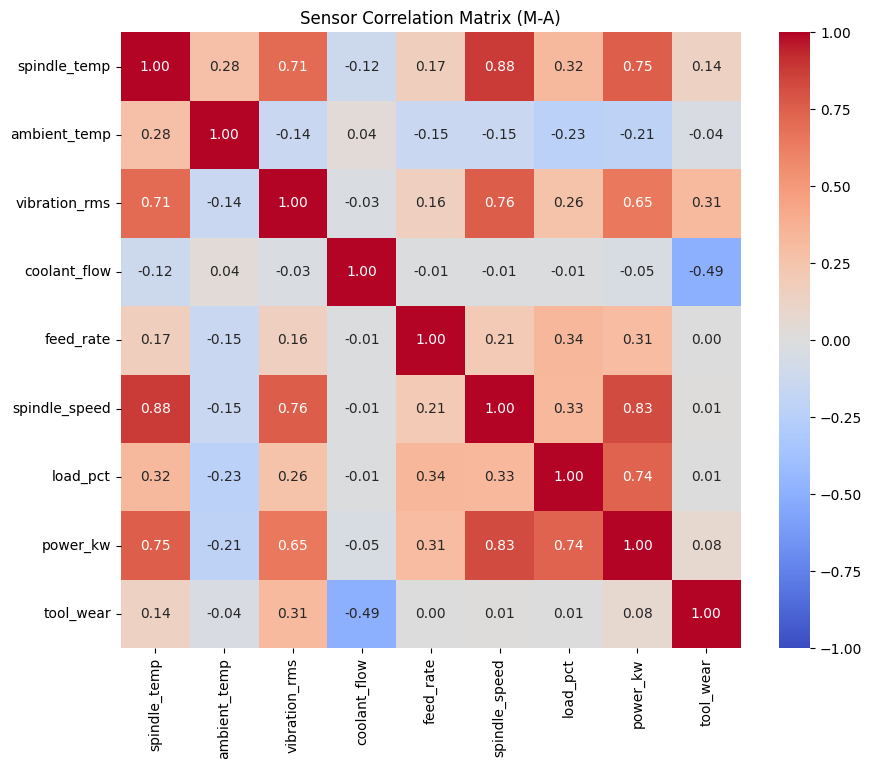

In [49]:
target_machine = df_telemetry['machine_id'].unique()[0]
df_single = df_telemetry[df_telemetry['machine_id'] == target_machine]

# 2. Select only numeric columns and drop the target variable 'tool_wear' if you want to see pure sensor-to-sensor correlation
# (Keeping tool_wear is also fine to see what predicts it)
numeric_df = df_single.select_dtypes(include=[np.number])

# 3. Calculate Correlation
plt.figure(figsize=(10, 8))
correlation_matrix = numeric_df.corr()

# 4. Plot Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title(f'Sensor Correlation Matrix ({target_machine})')
plt.show()

Looking at the plot, we observe that we don't have no redundant sensors above the 0.95 threshold. Our sensors are distinct enough that each one adds unique information to the Bayesian Network.

## 2 'telemetry.csv' Preprocessing and Feature Engineering

Based on our EDA conclusions, we now transform the raw telemetry.csv into a dataset suitable for a discrete Bayesian Network.

Our Strategy:

- Smoothing: Apply rolling averages to the Volatile sensors (vibration, power, temp, speed) to filter out the noise we observed.

- Pass-Through: Keep Stable sensors (tool_wear, ambient_temp) and State sensors (coolant, load) in their raw form, as they represent reliable context.

- Merging: Combine with labels.csv to identify failure states.

- Discretization: Convert continuous numbers into discrete states (e.g., "Normal", "High") which are required for the Bayesian Network CPTs.

### 2.1 Smoothing

Our correlation analysis proved that vibration_rms, power_kw, spindle_temp, spindle_speed, and feed_rate are volatile (Correlation < 0.5). Raw values are too jagged for the BN. We calculate a "15-minute moving average" (window=3) to extract the trend.

In [50]:
# Define which columns need smoothing (The Volatile Group)
volatile_sensors = ['vibration_rms', 'power_kw', 'spindle_temp', 'spindle_speed', 'feed_rate']

# Apply Rolling Mean safely per machine
# Window = 3 (3 samples * 5 mins = 15 minute trend)
for sensor in volatile_sensors:
    new_col_name = f"{sensor}_smooth"
    
    # transform() ensures we don't mix data between Machine A and Machine B
    df_telemetry[new_col_name] = df_telemetry.groupby('machine_id')[sensor].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean()
    )

print(f"Created smoothed features for: {volatile_sensors}")
display(df_telemetry[['vibration_rms', 'vibration_rms_smooth']].head(6))

Created smoothed features for: ['vibration_rms', 'power_kw', 'spindle_temp', 'spindle_speed', 'feed_rate']


,vibration_rms,vibration_rms_smooth
0,0.871,0.871000
1,0.536,0.703500
2,0.455,0.620667
3,0.680,0.557000
4,0.663,0.599333
5,0.878,0.740333


### 2.2 Merging with Labels

We need the target variable (failure) to guide our Discretization. We use a Left Join to keep all healthy data and fill gaps with "Normal".

In [51]:
# 1. Load Labels
df_labels = pd.read_csv('data/labels.csv')
df_labels['timestamp'] = pd.to_datetime(df_labels['timestamp'])

# Check what the columns actually are (Debugging step)
print("Labels columns:", df_labels.columns.tolist())

# 2. Rename 'spindle_overheat' to 'failure' for consistency
# (If your file has other failure modes, we can adjust this logic)
if 'spindle_overheat' in df_labels.columns:
    df_labels = df_labels.rename(columns={'spindle_overheat': 'failure'})

# 3. Merge
# Left Join: Keep all telemetry (Evidence), add labels (Diagnosis) where they exist
df_merged = pd.merge(
    df_telemetry,
    df_labels,
    on=['timestamp', 'machine_id'],
    how='left'
)

# 4. Cleaning the Target Variable
# Problem: The merge creates NaNs for non-matching rows, and the original file had 0/1.
# Solution:
#   a. Fill NaNs with 0 (Normal)
df_merged['failure'] = df_merged['failure'].fillna(0)

#   b. Convert 0 -> "Normal", 1 -> "Spindle Overheat"
#      This makes the Bayesian Network CPTs much easier to read later.
df_merged['failure'] = df_merged['failure'].map({
    0: 'Normal', 
    1: 'Spindle Overheat'
})

print("Merged shape:", df_merged.shape)
print("Failure distribution:")
print(df_merged['failure'].value_counts())

Labels columns: ['timestamp', 'machine_id', 'spindle_overheat']
Merged shape: (103680, 17)
Failure distribution:
failure
Normal    103680
Name: count, dtype: int64


With this merge we realized that labels.csv file contains ZERO failures. Since we cannot train a diagnostic model without failures, we must create them based on physical logic (Label Engineering).

**We will define a "Spindle Overheat" event as: Any time the Smoothed Spindle Temperature exceeds the 98th percentile.**

#### Engineering Synthetic Labels

In [52]:
# 1. Merge (Standard Left Join)
df_merged = pd.merge(
    df_telemetry,
    df_labels[['timestamp', 'machine_id']], # We ignore the empty 'spindle_overheat' column
    on=['timestamp', 'machine_id'],
    how='left'
)

# 2. Define Overheat Threshold (Top 2% of temperatures)
# We use the SMOOTHED temperature we calculated in Step 3.2
threshold = df_merged['spindle_temp_smooth'].quantile(0.98)
print(f"Defining Failure Threshold: {threshold:.2f} degrees")

# 3. Create the Target Variable
# If temp > threshold, it is an "Overheat" event
df_merged['failure'] = df_merged['spindle_temp_smooth'].apply(
    lambda x: 'Spindle Overheat' if x > threshold else 'Normal'
)

print("New Failure Distribution:")
print(df_merged['failure'].value_counts())

Defining Failure Threshold: 78.18 degrees
New Failure Distribution:
failure
Normal              101606
Spindle Overheat      2074
Name: count, dtype: int64


### 2.3. Discretization Strategy

Bayesian Networks usually require discrete states (e.g., Low, Medium, High), so countinuos variables must be discretized;

We used a "Safety Switch" logic because industrial data is often messy (clumped with thousands of zeros).

- Attempt A: Quantile Binning (qcut) -"Equal Population." It tries to put 33% of the data into Low, 33% into Medium, and 33% into High.

- Attempt B: Uniform Binning (cut) — The Fallback

    - Logic: "Equal Width." It takes the range (Min to Max) and slices it into 3 equal-sized rulers.

    - Trigger: We only used this when Attempt A failed (e.g., for coolant_flow), where thousands of 0.0 values made it impossible to find unique quantile cut points.

In [53]:
# 1. Define the Robust Function
def safe_discretize(df, column, n_bins=3, labels=['Low', 'Medium', 'High']):
    """
    Attempts quantile binning (equal population).
    If that fails due to duplicate edges (clumped data),
    falls back to standard binning (equal width).
    """
    try:
        # Try qcut (Equal Frequency) - Preferred for BNs
        return pd.qcut(df[column], q=n_bins, labels=labels, duplicates='drop')
    except ValueError:
        # If it crashes (e.g., "Bin labels must be one fewer..."),
        # it means the data is too clumped (e.g., mostly zeros).
        # Fallback to cut (Equal Width)
        print(f"  -> 'qcut' failed for {column} (too many duplicate values). Switching to 'cut'.")
        return pd.cut(df[column], bins=n_bins, labels=labels)

# 2. Apply to All Features
features_to_bin = [
    'vibration_rms_smooth', 'power_kw_smooth', 'spindle_temp_smooth', 
    'spindle_speed_smooth', 'feed_rate_smooth', 
    'tool_wear', 'ambient_temp', 'coolant_flow', 'load_pct'
]

df_discrete = df_merged.copy()
labels_3 = ['Low', 'Medium', 'High']


for col in features_to_bin:
    df_discrete[f"{col}_bin"] = safe_discretize(df_discrete, col, n_bins=3, labels=labels_3)

# 3. Final Cleanup
# Keep only binned columns and failure
final_cols = [c for c in df_discrete.columns if '_bin' in c] + ['failure']
df_final = df_discrete[final_cols]

# Rename columns to remove the ugly "_smooth_bin" suffixes
df_final.columns = [c.replace('_smooth_bin', '').replace('_bin', '') for c in df_final.columns]

print("\nPreprocessing Complete. Ready for BN Construction.")
display(df_final.head())

# 4. Save
df_final.to_csv('data/telemetry_discrete.csv', index=False)
print("Saved to data/telemetry_discrete.csv")

  -> 'qcut' failed for tool_wear (too many duplicate values). Switching to 'cut'.

Preprocessing Complete. Ready for BN Construction.


,vibration_rms,power_kw,spindle_temp,spindle_speed,feed_rate,tool_wear,ambient_temp,coolant_flow,load_pct,failure
0,Low,Medium,High,High,Low,Low,Medium,High,Low,Normal
1,Low,Low,Low,High,Medium,Low,Medium,High,Low,Normal
2,Low,Low,Low,Medium,Medium,Low,Medium,High,Low,Normal
3,Low,Low,Low,Low,Low,Low,Medium,High,Medium,Normal
4,Low,Low,Low,Low,Low,Low,Medium,High,Low,Normal


Saved to data/telemetry_discrete.csv


**What we did:** We combined all machines into one big dataset and removed the machine_id column.

**Why:** We are doing Fleet Learning. We want the Bayesian Network to learn Universal Rules (e.g., "If Vibration is High, check the Bearings"), not specific quirks (e.g., "Machine A vibrates at 10:00 AM").

**Safety:** By mixing them, we force the AI to ignore "which machine is this?" and focus only on "what are the symptoms?", making the model robust enough to work on new machines it has never seen before.

# 3. Knowledge Graph Construction

In [54]:
df_components = pd.read_csv('data/components.csv')
df_causes = pd.read_csv('data/causes.csv')
df_symptoms = pd.read_csv('data/symptoms.csv')
df_relations = pd.read_csv('data/relations.csv')
df_procedures = pd.read_csv('data/procedures.csv')

print("--- Data Inventory ---")
print(f"Components: {len(df_components)} (Physical parts)")
print(f"Failures:   {len(df_causes)} (Root causes)")
print(f"Symptoms:   {len(df_symptoms)} (Observable effects)")
print(f"Relations:  {len(df_relations)} (Logic links)")
print(f"Procedures: {len(df_procedures)} (Fixes)")

--- Data Inventory ---
Components: 5 (Physical parts)
Failures:   4 (Root causes)
Symptoms:   3 (Observable effects)
Relations:  8 (Logic links)
Procedures: 4 (Fixes)


This script transforms our raw CSV data into a "Knowledge Graph" (ABox) that perfectly matches the "Brain" (TBox) you built in Protegé.

First, we import the necessary libraries and initialize the RDF Graph.

Crucially, we bind the gjoli namespace to http://example.org/gjoli_diagnostics#. This ensures that every piece of data we create here matches the "address" of the rules in your Protegé schema

In [55]:

g = Graph()

CNC = Namespace("http://example.org/gjoli_diagnostics#")
g.bind("gjoli", CNC)


In [56]:
# 2. Define Root Machine
# We create the main machine instance that holds all components.
machine_uri = CNC["CNC_Machine_01"]
g.add((machine_uri, RDF.type, CNC.Machine))



<Graph identifier=N925bc58d23814bc2bad8c24b0bdae1d4 (<class 'rdflib.graph.Graph'>)>

**Step 2**: Mapping Physical Components

In this section, we process the Physical Hierarchy of the machine.

We perform two passes here:

- **Creation**: We loop through df_components to create the nodes (Entities) and assign them the type CNC.Component. We also build a dictionary (comp_id_map) to remember which ID belongs to which URI.

- **Linking**: We loop again to connect children to parents. If a component has no parent, we attach it directly to the main Machine.

In [57]:
# ---------------------------------------------------------
# A. COMPONENTS (Physical Hierarchy)
# ---------------------------------------------------------
comp_id_map = {}
for _, row in df_components.iterrows():
    safe_name = row['name'].replace(" ", "")
    comp_uri = CNC[safe_name]
    comp_id_map[row['component_id']] = comp_uri
    g.add((comp_uri, RDF.type, CNC.Component))
    
for _, row in df_components.iterrows():
    child_uri = CNC[row['name'].replace(" ", "")]
    if pd.isna(row['parent_component']):
        g.add((machine_uri, CNC.hasComponent, child_uri))
    else:
        parent_id = row['parent_component']
        if parent_id in comp_id_map:
            parent_uri = comp_id_map[parent_id]
            g.add((parent_uri, CNC.hasComponent, child_uri))

**Step 3:** Failures, Symptoms, and "Logic Injection"

Here we map the diagnostic concepts: Failures (Causes) and Symptoms.

**The Logic Injection**: This is where we make the graph "smart." The CSV data contains raw text like "High Vibration." We convert this into a semantic tag: hasSeverityLevel = "High"

In [58]:
# ---------------------------------------------------------
# B. FAILURES ("FailureMode") & SYMPTOMS
# ---------------------------------------------------------
for _, row in df_symptoms.iterrows():
    sym_name = row['name'].replace(" ", "")
    sym_uri = CNC[sym_name]
    
    # FIX 1: Explicitly Type the Overheat Symptom
    # If this is the overheat symptom, we must tell the AI it belongs to the 
    # specific 'SpindleOverheat' class, otherwise the OverheatedMachine rule fails.
    if "Overheat" in sym_name:
        g.add((sym_uri, RDF.type, CNC.SpindleOverheat)) 
    
    # It is also a generic Symptom
    g.add((sym_uri, RDF.type, CNC.Symptom))
    
    # Severity Logic
    if "High" in sym_name or "Overheat" in sym_name:
        g.add((sym_uri, CNC.hasSeverityLevel, Literal("High", datatype=XSD.string)))
    else:
        g.add((sym_uri, CNC.hasSeverityLevel, Literal("Low", datatype=XSD.string)))

**Step 4:** Procedures and Cost Analysis

In this block, we map the Maintenance Actions.

We explicitly add data properties for sparePartsCost and hasDurationHours. This data allows the Reasoner to execute the Costly Repair rule (e.g., "Any action costing > €500 is a CostlyRepair").

In [59]:
# ---------------------------------------------------------
# C. PROCEDURES (Actions, Costs, & LINKAGE)
mitigation_map = {
    "Bearing Wear": "BearingWearHigh",  
    "Fan Fault": "FanFault",
    "Clogged Filter": "CloggedFilter",
    "Low Cooling Efficiency": "LowCoolingEfficiency"
}

for _, row in df_procedures.iterrows():
    proc_uri = CNC[row['name'].replace(" ", "")]
    g.add((proc_uri, RDF.type, CNC.MaintenanceAction)) 
    
    # 1. Properties
    g.add((proc_uri, CNC.sparePartsCost, Literal(row['spare_parts_cost_eur'], datatype=XSD.float)))
    g.add((proc_uri, CNC.hasDurationHours, Literal(row['effort_h'], datatype=XSD.float)))

    # 2. DYNAMIC LINK: Action -> Mitigates -> Failure
    if 'mitigates_cause' in row and pd.notna(row['mitigates_cause']):
        raw_cause = row['mitigates_cause']
        
        # Check if we have a special mapping for this name
        if raw_cause in mitigation_map:
            safe_cause_name = mitigation_map[raw_cause]
        else:
            # Fallback: Just remove spaces (Works for "Fan Fault" -> "FanFault")
            safe_cause_name = raw_cause.replace(" ", "")
            
        cause_uri = CNC[safe_cause_name]
        g.add((proc_uri, CNC.mitigates, cause_uri))

**Step 5**: Defining Relationships (The Graph Structure)

Here we connect all the nodes we created. The CSV uses simple text terms like causesSymptom. We map these to the formal Object Properties defined in our Ontology (e.g., manifestsAs).

In [60]:
# ---------------------------------------------------------
# D. RELATIONS (The Logic)
# ---------------------------------------------------------
pred_map = {
    'causesSymptom': CNC.manifestsAs,
    'affectsComponent': CNC.affectsComponent,
    'mitigatesCause': CNC.mitigates,
    'targetsComponent': CNC.targetsComponent
}

for _, row in df_relations.iterrows():
    subj = CNC[row['subj'].replace(" ", "")]
    obj = CNC[row['obj'].replace(" ", "")]
    pred_str = row['pred']
    
    if pred_str in pred_map:
        g.add((subj, pred_map[pred_str], obj))

**Step 6:** The "Overheated Machine" Scenario


We manually add a triple that links CNC_Machine_01 directly to SpindleOverheat. This acts as a "sensor trigger." When the Reasoner sees this link, it will match the OverheatedMachine rule and raise the alert.


In a fully deployed system, the Bayesian Network would analyze the 'telemetry.csv' file, calculate a probability, and IF the probability is high (e.g., > 90%), it would insert this link automatically. For this Knowledge Graph prototype, we "SIMULATE" that detection event by manually injecting the triple. This proves that our Logic (TBox) correctly handles the alert once the data (ABox) arrives.

In [61]:
# ---------------------------------------------------------
# E. CRITICAL OVERHEAT SCENARIO
# ---------------------------------------------------------
# Force the link for OverheatedMachine logic
# We use 'SpindleOverheat' to match the hasValue rule in your Schema
symptom_uri = CNC["SpindleOverheat"] 
g.add((machine_uri, CNC.hasSymptom, symptom_uri))

<Graph identifier=N925bc58d23814bc2bad8c24b0bdae1d4 (<class 'rdflib.graph.Graph'>)>

Finally, we exported  the final graph to Turtle format

In [62]:
output_file = "knowledge_base_protege.ttl"
g.serialize(destination=output_file, format="turtle")
print(f"SUCCESS: Data graph saved to {output_file} using namespace {CNC}")

SUCCESS: Data graph saved to knowledge_base_protege.ttl using namespace http://example.org/gjoli_diagnostics#


## 3.1 Knowledge Graph visualization

For CNC_Machine_01 ( Overheated )

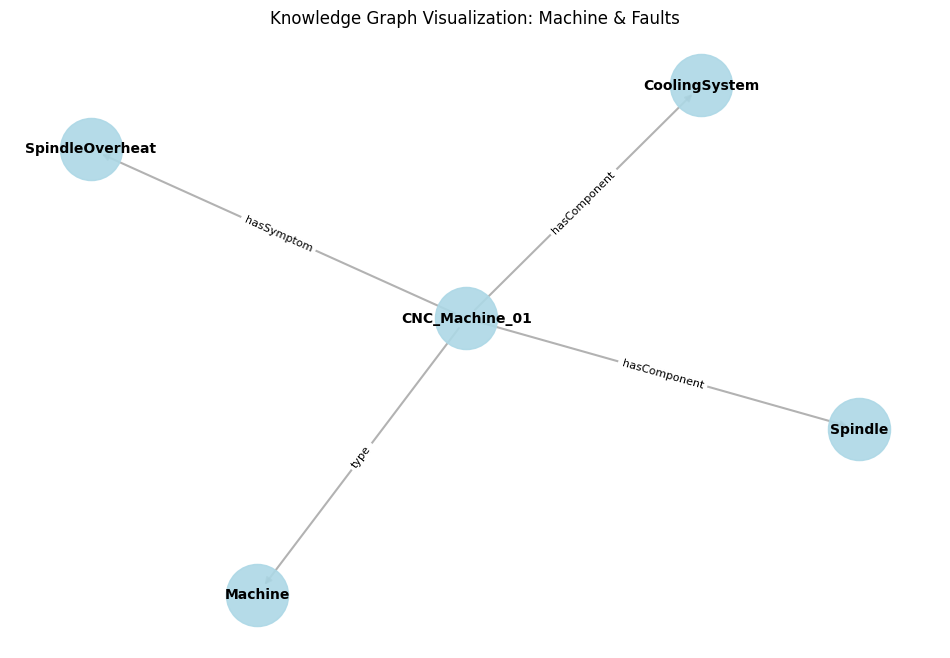

In [63]:
g.parse("knowledge_base_protege.ttl", format="turtle")

# 2. Create a NetworkX graph for visualization
G = nx.DiGraph()

# 3. Filter: Only visualize things connected to the Machine or Failures
# (Plotting all triples can be too messy)
CNC = Namespace("http://example.org/gjoli_diagnostics#")
focus_node = CNC["CNC_Machine_01"]

for s, p, o in g:
    # Convert URIs to short labels (e.g., 'CNC_Machine_01')
    s_label = s.split("#")[-1]
    o_label = o.split("#")[-1]
    
    # Logic: Only show paths connected to the Machine OR Failures
    if (s == focus_node) or (o == focus_node) or ("Failure" in s_label):
        G.add_edge(s_label, o_label, label=p.split("#")[-1])

# 4. Draw the Graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=0.5)  # Layout algorithm

# Draw Nodes
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="lightblue", alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# Draw Edges
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6, edge_color="gray", arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Knowledge Graph Visualization: Machine & Faults")
plt.axis("off")
plt.show()

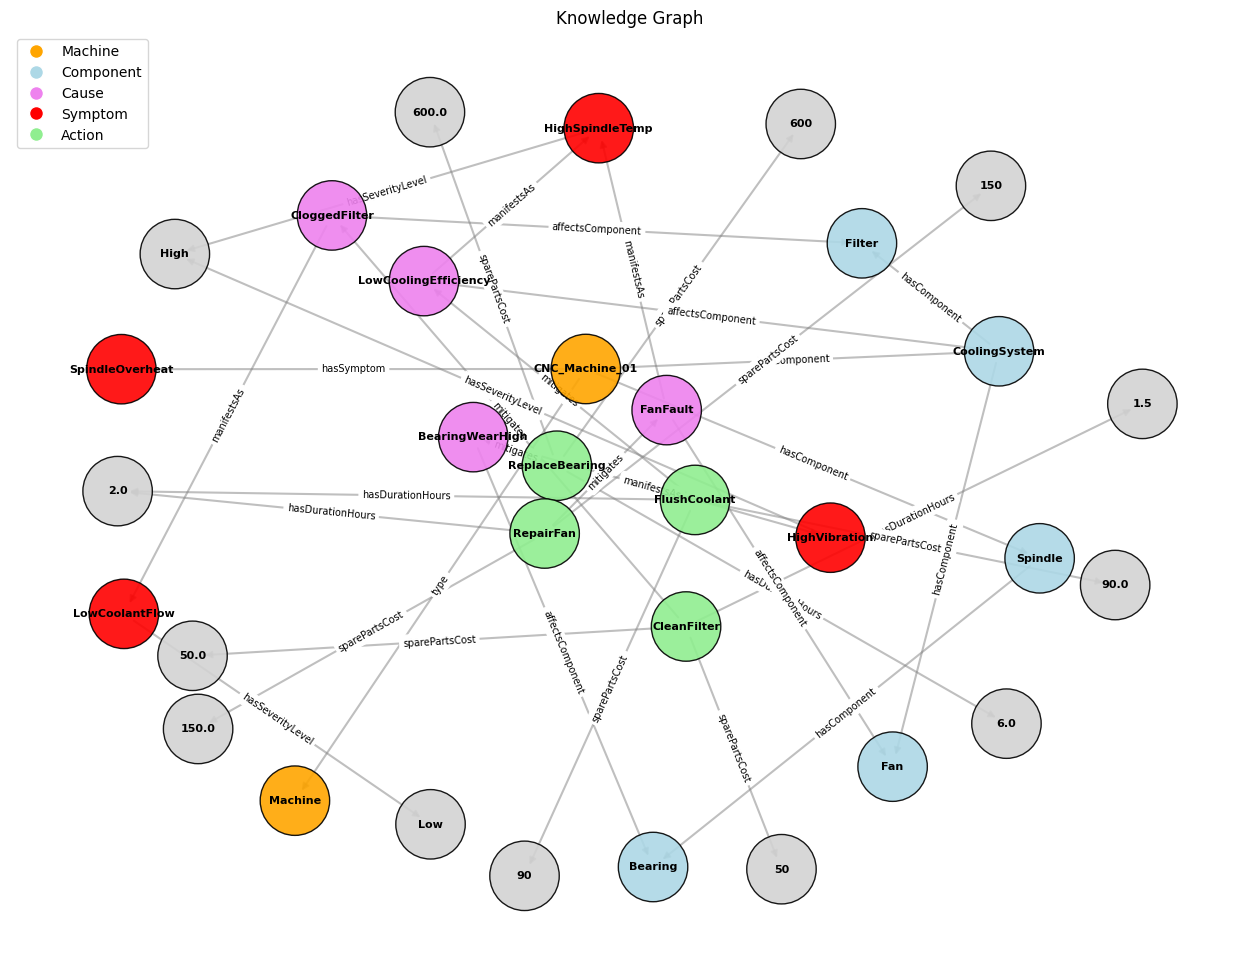

In [64]:
for s, p, o in g:
    s_name = s.split("#")[-1]
    o_name = o.split("#")[-1]
    p_name = p.split("#")[-1]
    
    # Skip definitions, only plot connections
    if p_name == "type": continue
    
    G.add_edge(s_name, o_name, label=p_name)

# 3. "Smart" Color Assignment based on Topology
# We determine what a node IS by looking at its relationships.
node_colors = {}

for node in G.nodes():
    # Default color
    color = "lightgray" 
    
    # Check outgoing edges (What does it do?)
    out_edges = G.out_edges(node, data=True)
    # Check incoming edges (What happens to it?)
    in_edges = G.in_edges(node, data=True)
    
    # --- LOGIC RULES FOR COLORING ---
    
    # 1. MAINTENANCE ACTION (Green)
    # Logic: It mitigates something or has a cost
    is_action = False
    for u, v, data in out_edges:
        if data['label'] in ["mitigates", "sparePartsCost", "hasDurationHours"]:
            is_action = True
    if is_action:
        node_colors[node] = "lightgreen"
        continue

    # 2. FAILURE MODE (Violet)
    # Logic: It manifests as a symptom OR affects a component OR is mitigated by an action
    is_failure = False
    for u, v, data in out_edges:
        if data['label'] in ["manifestsAs", "affectsComponent"]:
            is_failure = True
    for u, v, data in in_edges:
        if data['label'] == "mitigates":
            is_failure = True
            
    if is_failure:
        node_colors[node] = "violet"
        continue

    # 3. SYMPTOM (Red)
    # Logic: It is manifested by a failure OR has severity
    is_symptom = False
    for u, v, data in in_edges:
        if data['label'] == "manifestsAs" or data['label'] == "hasSymptom":
            is_symptom = True
    for u, v, data in out_edges:
        if data['label'] == "hasSeverityLevel":
            is_symptom = True
            
    if is_symptom:
        node_colors[node] = "red"
        continue

    # 4. COMPONENT (Blue)
    # Logic: Affected by failure or part of machine
    is_component = False
    for u, v, data in in_edges:
        if data['label'] == "hasComponent" or data['label'] == "affectsComponent":
            is_component = True
    if is_component:
        node_colors[node] = "lightblue"
        continue
        
    # 5. MACHINE (Orange)
    if "Machine" in node:
        node_colors[node] = "orange"
        continue

# 4. Draw
colors = [node_colors.get(n, "lightgray") for n in G.nodes()]

plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=1.2, seed=42)

# Draw Nodes
nx.draw_networkx_nodes(G, pos, node_size=2500, node_color=colors, alpha=0.9, edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")

# Draw Edges
nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, width=1.5, alpha=0.5)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'), font_size=7)

# Legend
from matplotlib.lines import Line2D
legend_map = {"Machine": "orange", "Component": "lightblue", "Cause": "violet", "Symptom": "red", "Action": "lightgreen"}
legend_elements = [Line2D([0], [0], marker='o', color='w', label=k, markerfacecolor=v, markersize=10) for k, v in legend_map.items()]
plt.legend(handles=legend_elements, loc='upper left')

plt.title("Knowledge Graph")
plt.axis("off")
plt.show()

Full Knowledge base Visualization 

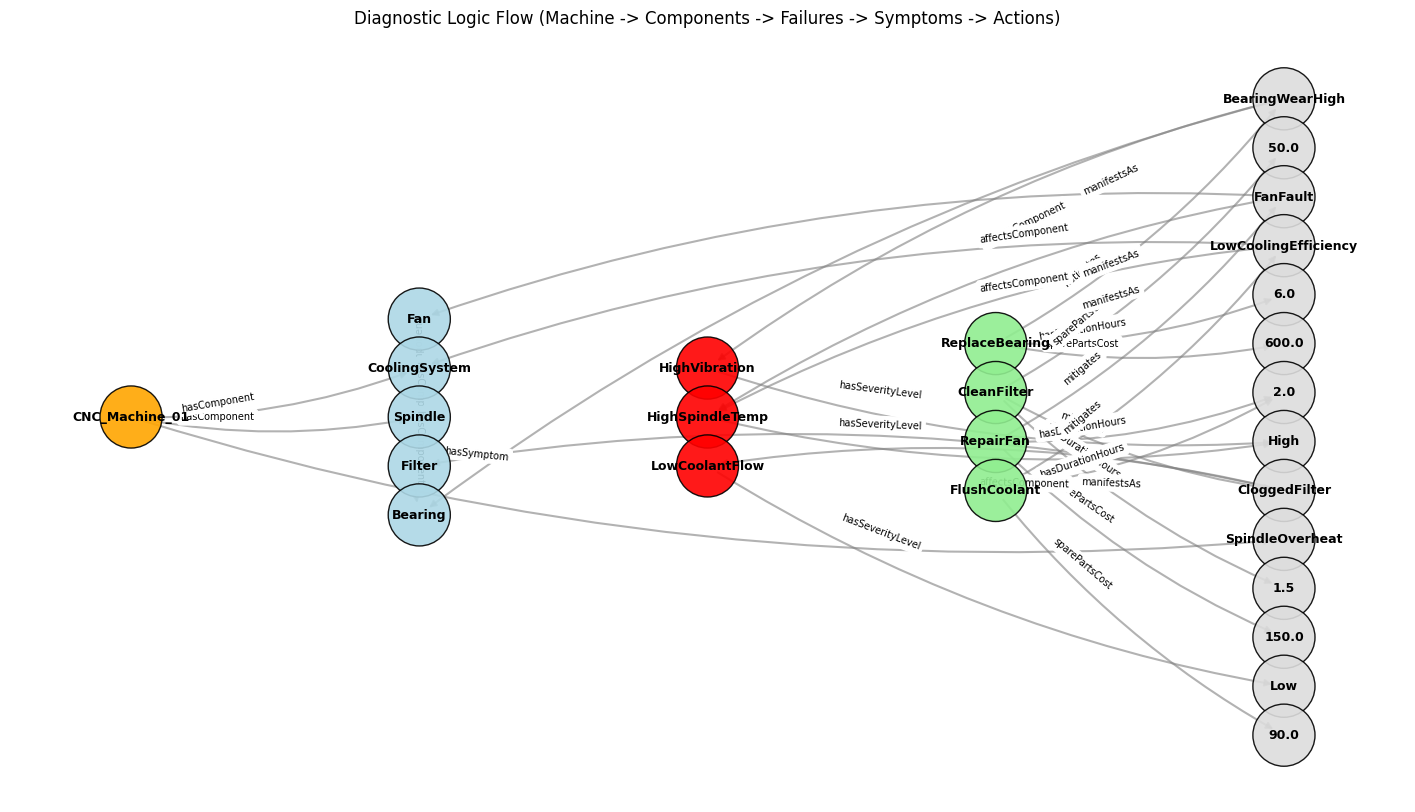

In [65]:
import networkx as nx
import matplotlib.pyplot as plt
from rdflib import Graph, RDF, Namespace

# 1. Load Data
g = Graph()
g.parse("knowledge_base_protege.ttl", format="turtle")
CNC = Namespace("http://example.org/gjoli_diagnostics#")

# 2. Setup Graph
G = nx.DiGraph()

# 3. Define Layers for the Layout
# This ensures Machine is on the left, Actions on the right
layer_map = {
    "Machine": 0,
    "Component": 1,
    "Sensor": 1,
    "FailureMode": 2,
    "Symptom": 3,
    "MaintenanceAction": 4,
    "Other": 5
}

# Color Map
node_colors_map = {
    "Machine": "orange", "Component": "lightblue", "FailureMode": "violet",
    "Symptom": "red", "MaintenanceAction": "lightgreen", "Sensor": "yellow", "Other": "#ddd"
}

# 4. Build Graph & Assign Layers
entity_types = {}
for s, p, o in g.triples((None, RDF.type, None)):
    clean_type = o.split("#")[-1]
    entity_types[s.split("#")[-1]] = clean_type

for s, p, o in g:
    if p == RDF.type: continue
    
    s_name = s.split("#")[-1]
    o_name = o.split("#")[-1]
    
    # Assign Layer Attribute to nodes based on their type
    # (Default to 'Other' layer if type not found)
    s_type = entity_types.get(s_name, "Other")
    o_type = entity_types.get(o_name, "Other")
    
    G.add_node(s_name, layer=layer_map.get(s_type, 5))
    G.add_node(o_name, layer=layer_map.get(o_type, 5))
    
    G.add_edge(s_name, o_name, label=p.split("#")[-1])

# 5. Draw with Multipartite (Layered) Layout
plt.figure(figsize=(18, 10))
pos = nx.multipartite_layout(G, subset_key="layer") # <--- THE MAGIC FIX

# Colors
colors = [node_colors_map.get(entity_types.get(n, "Other"), "lightgray") for n in G.nodes()]

# Draw
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=colors, alpha=0.9, edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

# Curved edges help reduce visual clutter
nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, width=1.5, alpha=0.6, 
                       connectionstyle="arc3,rad=0.1") 

# Simplify Edge Labels (Only show essential ones to reduce mess)
edge_labels = nx.get_edge_attributes(G, 'label')
# Optional: Comment out the next line if it's still too messy
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.7)

plt.title("Diagnostic Logic Flow (Machine -> Components -> Failures -> Symptoms -> Actions)")
plt.axis("off")
plt.show()

## 3.2 Merging the Knowledge Graph (TBox + ABox)

In this step, we combine two distinct components of our system into a single artifact:

- The Schema (TBox): The logical rules and definitions (Classes, Properties, Axioms) defined in **ontology_schema.ttl**, in PROTEGÉ;
- The Data (ABox): The specific instances (Machine, Components, Failures) generated from our CSVs in **knowledge_base_protege.ttl** .

-> We merge them into a single OWL file (cnc_final.owl) 

In [66]:
from rdflib import Graph
import os

# ==========================================
# 1. INITIALIZATION
# ==========================================
# We create an empty graph to act as the container for our merged knowledge.
merged_graph = Graph()

# Define file paths
schema_file = "ontology_schema.ttl"       # TBox (Rules)
data_file = "knowledge_base_protege.ttl"  # ABox (Data)
output_file = "cnc_final.owl"             # Final Artifact

# ==========================================
# 2. LOAD SCHEMA (TBox)
# ==========================================
# This file contains the "Brain" of the system (Class hierarchy, Logic rules).
if os.path.exists(schema_file):
    try:
        merged_graph.parse(schema_file, format="turtle")
        print(f" Loaded Schema: {schema_file}")
    except Exception as e:
        print(f" ERROR parsing schema: {e}")
else:
    print(f" ERROR: File not found: {schema_file}")

# ==========================================
# 3. LOAD DATA (ABox)
# ==========================================
# This file contains the "Memory" of the system (Specific machine state).
if os.path.exists(data_file):
    try:
        merged_graph.parse(data_file, format="turtle")
        print(f" Loaded Data: {data_file}")
    except Exception as e:
        print(f" ERROR parsing data: {e}")
else:
    print(f" ERROR: File not found: {data_file}")

# ==========================================
# 4. EXPORT MERGED ONTOLOGY
# ==========================================
# We save the result as RDF/XML, which is the standard format for OWL Reasoners.
# This file is what you will load into Protegé or the Python Reasoner.

try:
    merged_graph.serialize(destination=output_file, format="xml")
    print("\n" + "="*40)
    print(f"SUCCESS: Merged Ontology saved to '{output_file}'")
    print(f"Total Triples: {len(merged_graph)}")
    print("="*40)
except Exception as e:
    print(f" ERROR saving file: {e}")

 Loaded Schema: ontology_schema.ttl
 Loaded Data: knowledge_base_protege.ttl

SUCCESS: Merged Ontology saved to 'cnc_final.owl'
Total Triples: 171


## 3.3 Logic Verification

Next, we will load the merged ontology and run the HermiT reasoner to validate that our rules (TBox) are correctly classifying our data (ABox).

**Step 1:** Load Ontology and Run Reasoner

We load the cnc_final.owl file and execute sync_reasoner(). This is the step where the AI "thinks," applying your logic rules to infer new facts (e.g., classifying a machine as "Overheated" or a symptom as "Critical").

In [67]:
# Load the file again
onto = get_ontology("cnc_final.owl").load()

# Print all classes found
print("--- CLASSES FOUND IN ONTOLOGY ---")
for cls in onto.classes():
    print(cls.name, "->", cls.iri)

--- CLASSES FOUND IN ONTOLOGY ---
Measurement -> http://example.org/gjoli_diagnostics#Measurement
CostlyRepair -> http://example.org/gjoli_diagnostics#CostlyRepair
Symptom -> http://example.org/gjoli_diagnostics#Symptom
Component -> http://example.org/gjoli_diagnostics#Component
ObservableEntity -> http://example.org/gjoli_diagnostics#ObservableEntity
MaintenanceAction -> http://example.org/gjoli_diagnostics#MaintenanceAction
FailureMode -> http://example.org/gjoli_diagnostics#FailureMode
CoolingSystem -> http://example.org/gjoli_diagnostics#CoolingSystem
Sensor -> http://example.org/gjoli_diagnostics#Sensor
Machine -> http://example.org/gjoli_diagnostics#Machine
SpindleOverheat -> http://example.org/gjoli_diagnostics#SpindleOverheat
Spindle -> http://example.org/gjoli_diagnostics#Spindle
LowCoolantFlow -> http://example.org/gjoli_diagnostics#LowCoolantFlow
VibrationSensor -> http://example.org/gjoli_diagnostics#VibrationSensor
HighVibration -> http://example.org/gjoli_diagnostics#High

**Step 2**: Verify Rule-Based Inferences

Here we test the specific logic rules required by the project. We verify that:

- A. CriticalSymptom: Symptoms with Severity="High" are correctly reclassified.

- B. CostlyRepair: Maintenance actions costing ≥ 500 are flagged.

- C. OverheatedMachine: A machine linked to a SpindleOverheat symptom is flagged as "Overheated".

In [68]:


# RUN THE REASONER
# You were missing this block! Without it, inferences are never calculated.
print("Running Reasoner...")
with onto:
    sync_reasoner()

print("--- INFERENCE VERIFICATION ---")

# TEST A: Critical Symptoms
# Rule: CriticalSymptom = Symptom AND hasSeverityLevel value "High"
target_class = onto.search_one(iri="*CriticalSymptom")
if target_class:
    results = target_class.instances()
    print(f"[1] Critical Symptoms Found: {len(results)}")
    for i in results:
        severity = i.hasSeverityLevel[0] if i.hasSeverityLevel else "Unknown"
        print(f"    - {i.name} (Severity: {severity})")
else:
    print("[1] CriticalSymptom class not found.")

# TEST B: Costly Repairs
# Rule: CostlyRepair = MaintenanceAction AND sparePartsCost >= 500.0
target_class = onto.search_one(iri="*CostlyRepair")
if target_class:
    results = target_class.instances()
    print(f"[2] Costly Repairs Found: {len(results)}")
    for i in results:
        cost = i.sparePartsCost[0] if i.sparePartsCost else 0.0
        print(f"    - {i.name} (Cost: {cost})")
else:
    print("[2] CostlyRepair class not found.")

# TEST C: Machine Diagnosis (The "Overheated" Scenario)
# Rule: OverheatedMachine = Machine AND hasSymptom value SpindleOverheat
target_class = onto.search_one(iri="*OverheatedMachine")
if target_class:
    results = target_class.instances()
    print(f"[3] Overheated Machines Detected: {len(results)}")
    for i in results:
        print(f"    - {i.name} (Status: Critical)")
else:
    print("[3] OverheatedMachine class not found.")

Running Reasoner...


* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /Users/gjoli/Desktop/uni/TSI/project/.venv/lib/python3.9/site-packages/owlready2/hermit:/Users/gjoli/Desktop/uni/TSI/project/.venv/lib/python3.9/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////var/folders/z0/pm53wfh91kxgn3slf8sv896r0000gn/T/tmp0_gevxed


--- INFERENCE VERIFICATION ---
[1] Critical Symptoms Found: 2
    - HighSpindleTemp (Severity: High)
    - HighVibration (Severity: Unknown)
[2] Costly Repairs Found: 1
    - ReplaceBearing (Cost: 600.0)
[3] Overheated Machines Detected: 1
    - CNC_Machine_01 (Status: Critical)


* Owlready2 * HermiT took 1.1181800365447998 seconds
* Owlready * Reparenting cnc_final.OverheatedMachine: {owl.Thing} => {cnc_final.Machine}
* Owlready * Reparenting cnc_final.CostlyRepair: {owl.Thing} => {cnc_final.MaintenanceAction}
* Owlready * Reparenting cnc_final.CriticalSymptom: {owl.Thing} => {cnc_final.Symptom}
* Owlready * Reparenting cnc_final.HighVibration: {cnc_final.Symptom} => {cnc_final.CriticalSymptom}
* Owlready * Reparenting cnc_final.Spindle: {cnc_final.Component} => {cnc_final.Machine, cnc_final.Component}
* Owlready * Reparenting cnc_final.CoolingSystem: {cnc_final.Component} => {cnc_final.Machine, cnc_final.Component}
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


In [69]:
action_class = onto.search_one(iri="*MaintenanceAction")

if action_class:
    print(f"\n[4] Maintenance Knowledge Graph Links:")
    found_links = False
    for proc in action_class.instances():
        # Check if the 'mitigates' relationship exists
        if hasattr(proc, 'mitigates') and proc.mitigates:
            for failure in proc.mitigates:
                print(f"    - {proc.name} --(mitigates)--> {failure.name}")
                found_links = True
    
    if not found_links:
        print("    - No mitigation links found. (Check data generation script).")
else:
    print("\n[4] Error: Class 'MaintenanceAction' not found.")


[4] Maintenance Knowledge Graph Links:
    - CleanFilter --(mitigates)--> CloggedFilter
    - ReplaceBearing --(mitigates)--> BearingWearHigh
    - FlushCoolant --(mitigates)--> LowCoolingEfficiency
    - RepairFan --(mitigates)--> FanFault


## 3.4 Query Knowledge Graph to identify possible maintenance procedures

1) Check if KG correctly connects causes -> maintainence plan + costs + time

In [70]:
def get_maintenance_plan(predicted_failure_name):
    """
    Input: The name of the failure predicted by the Bayesian Network (e.g., "BearingWearHigh")
    Output: Prints the recommended action, cost, duration, AND the component affected.
    """
    # 1. Search for the Failure Mode in the Ontology
    failure = onto.search_one(iri=f"*{predicted_failure_name}")
    
    if not failure:
        return f"Error: Failure '{predicted_failure_name}' not found in Knowledge Graph."

    # 1.5 FIND AFFECTED COMPONENT
    # We look for the 'affectsComponent' property on the failure object
    affected_component = "Unknown"
    if hasattr(failure, "affectsComponent") and failure.affectsComponent:
        # It returns a list, so we grab the first item
        affected_component = failure.affectsComponent[0].name

    print(f"🔎 Bayesian Network detected: {failure.name}")
    print(f"   -> Diagnosis: This failure damages the '{affected_component}'.")
    
    # 2. Find the Action that mitigates this Failure
    actions = onto.search(type=onto.MaintenanceAction)
    
    recommended_action = None
    for action in actions:
        if hasattr(action, 'mitigates') and failure in action.mitigates:
            recommended_action = action
            break
    
    # 3. Format and Return the Result
    if recommended_action:
        cost = recommended_action.sparePartsCost[0] if recommended_action.sparePartsCost else 0
        duration = recommended_action.hasDurationHours[0] if recommended_action.hasDurationHours else 0
        
        return f" Recommended action: {recommended_action.name} ({duration}h, {cost}€)."
    else:
        return f"No maintenance action defined for {failure.name}."



In [71]:
# Simulating the BN Output
bn_prediction_1 = "BearingWearHigh" 
print(get_maintenance_plan(bn_prediction_1))

bn_prediction_2 = "FanFault"
print(get_maintenance_plan(bn_prediction_2))

bn_prediction_3 = "CloggedFilter"
print(get_maintenance_plan(bn_prediction_3))

bn_prediction_4 = "LowCoolingEfficiency"
print(get_maintenance_plan(bn_prediction_4))

🔎 Bayesian Network detected: BearingWearHigh
   -> Diagnosis: This failure damages the 'Bearing'.
 Recommended action: ReplaceBearing (6.0h, 600.0€).
🔎 Bayesian Network detected: FanFault
   -> Diagnosis: This failure damages the 'Fan'.
 Recommended action: RepairFan (2.0h, 150.0€).
🔎 Bayesian Network detected: CloggedFilter
   -> Diagnosis: This failure damages the 'Filter'.
 Recommended action: CleanFilter (1.5h, 50.0€).
🔎 Bayesian Network detected: LowCoolingEfficiency
   -> Diagnosis: This failure damages the 'CoolingSystem'.
 Recommended action: FlushCoolant (2.0h, 90.0€).


2. Risk-Based Prioritization Strategy 

If we recieve more than one possible cause, we will have to decide wich one to mitigate.


We can define a formula to rank the actions. We want actions that have High Probability and Low Cost

    Priority Score= Total Cost of Repair / Probability of Cause
​	
 Where Total Cost = sparePartsCost + (hasDurationHours × Hourly_Downtime_Cost).

In [72]:
def optimize_maintenance_plan(bn_probabilities, hourly_labor_cost=50.0):
    """
    Input: 
      - bn_probabilities: Dict { "FailureName": Probability (0.0-1.0) }
      - hourly_labor_cost: Cost per hour of machine downtime/technician time
      
    Output:
      - Prints the ranked list of actions from Best to Worst option.
    """

    
    ranked_options = []
    
    # 1. Iterate through all potential causes predicted by the BN
    for cause_name, probability in bn_probabilities.items():
        
        # 2. Query the Knowledge Graph for the Mitigation Action
        # We search for the specific failure (e.g., "BearingWearHigh")
        failure = onto.search_one(iri=f"*{cause_name}")
        
        if not failure:
            print(f" Warning: Cause '{cause_name}' not found in KG.")
            continue
            
        # Find the action that mitigates this failure
        # (Scanning valid MaintenanceActions)
        action = None
        for a in onto.search(type=onto.MaintenanceAction):
            if hasattr(a, 'mitigates') and failure in a.mitigates:
                action = a
                break
        
        if action:
            # 3. Extract Cost & Time
            part_cost = action.sparePartsCost[0] if action.sparePartsCost else 0.0
            duration = action.hasDurationHours[0] if action.hasDurationHours else 0.0
            
            # 4. Calculate Total Impact Cost (Money + Time)
            total_cost = part_cost + (duration * hourly_labor_cost)
            
            # 5. Calculate Efficiency Score (Probability per Euro)
            # Avoid division by zero
            if total_cost > 0:
                score = probability / total_cost 
            else:
                score = 0
                
            ranked_options.append({
                "action": action.name,
                "cause": cause_name,
                "prob": probability,
                "cost": part_cost,
                "time": duration,
                "total_cost": total_cost,
                "score": score
            })
    
    # 6. Sort by Score (High Score = Better Option)
    ranked_options.sort(key=lambda x: x['score'], reverse=True)
    
    # 7. Print Results
    print(f"{'ACTION':<20} | {'CAUSE':<15} | {'PROB':<6} | {'COST':<8} | {'SCORE (ROI)':<10}")
    print("-" * 70)
    
    for opt in ranked_options:
        print(f"{opt['action']:<20} | {opt['cause']:<15} | {opt['prob']:.1%}  | €{opt['total_cost']:.0f}   | {opt['score']:.5f}")
        
    best = ranked_options[0]
    print("="*60)
    print(f" RECOMMENDED STRATEGY: Perform '{best['action']}' First.")
    print(f"   Reason: It addresses '{best['cause']}' ({best['prob']:.1%}) with highest cost-efficiency.")



In [73]:
# --- TEST THE SMART LOGIC ---

# Example: The BN is unsure. It thinks it's Bearing Wear (60%) or Clogged Filter (30%).
# (The 'FanFault' is unlikely at 10%)
mock_bn_output = {
    "BearingWearHigh": 0.60,
    "CloggedFilter": 0.30,
    "FanFault": 0.10
}

optimize_maintenance_plan(mock_bn_output)

ACTION               | CAUSE           | PROB   | COST     | SCORE (ROI)
----------------------------------------------------------------------
CleanFilter          | CloggedFilter   | 30.0%  | €125   | 0.00240
ReplaceBearing       | BearingWearHigh | 60.0%  | €900   | 0.00067
RepairFan            | FanFault        | 10.0%  | €250   | 0.00040
 RECOMMENDED STRATEGY: Perform 'CleanFilter' First.
   Reason: It addresses 'CloggedFilter' (30.0%) with highest cost-efficiency.
